6. Object detection using Transfer Learning of CNN architectures
<br>
a. Load in a pre-trained CNN model trained on a large dataset
<br>
b. Freeze parameters (weights) in model’s lower convolutional layers
<br>
c. Add custom classifier with several layers of trainable parameters to model
<br>
d. Train classifier layers on training data available for task
<br>
e. Fine-tune hyper parameters and unfreeze more layers as needed

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

2023-11-04 20:27:38.311047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Pre processing img data 

In [2]:
dataset_dir = "Datasets/caltech-101-img/"
dataset_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# here batch_size is the number of images in each batch
batch_size = 2000
dataset_generator = dataset_datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9144 images belonging to 102 classes.


#### Selecting first batch containing 2000 images as train and second batch containing 2000 images as test data

In [3]:
x_train, y_train =  dataset_generator[0]
x_test, y_test = dataset_generator[1]

print(len(x_train))
print(len(x_test))

2000
2000


#### a. Load in a pre-trained CNN model trained on a large dataset

In [4]:
# Load VGG16 without top layers
weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(64, 64, 3))

#### b. Freeze parameters (weights) in model’s lower convolutional layers

In [5]:
for layer in base_model.layers:
   layer.trainable = False

#### c. Add custom classifier with several layers of trainable parameters to model

In [7]:
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

#### d. Train classifier layers on training data available for task

In [8]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
32/32 [==============================] - 22s 670ms/step - loss: 3.9157 - accuracy: 0.2195 - val_loss: 3.3496 - val_accuracy: 0.2925
Epoch 2/10
32/32 [==============================] - 22s 701ms/step - loss: 3.0194 - accuracy: 0.3470 - val_loss: 2.9054 - val_accuracy: 0.3925
Epoch 3/10
32/32 [==============================] - 21s 671ms/step - loss: 2.5124 - accuracy: 0.4530 - val_loss: 2.6052 - val_accuracy: 0.4390
Epoch 4/10
32/32 [==============================] - 20s 631ms/step - loss: 2.1298 - accuracy: 0.5355 - val_loss: 2.3896 - val_accuracy: 0.4780
Epoch 5/10
32/32 [==============================] - 20s 634ms/step - loss: 1.8350 - accuracy: 0.5985 - val_loss: 2.2651 - val_accuracy: 0.4965
Epoch 6/10
32/32 [==============================] - 20s 649ms/step - loss: 1.6115 - accuracy: 0.6490 - val_loss: 2.1419 - val_accuracy: 0.5215
Epoch 7/10
32/32 [==============================] - 21s 657ms/step - loss: 1.4199 - accuracy: 0.6985 - val_loss: 2.0527 - val_accuracy: 0.5405

#### e. Fine-tune hyper parameters and unfreeze more layers as needed

In [9]:
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(64, 64, 3))
# freeze all layers first
for layer in base_model.layers:
   layer.trainable = False
# unfreeze last 4 layers of base model
for layer in base_model.layers[len(base_model.layers) - 2:]:
   layer.trainable = True
# fine-tuning hyper parameters
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(102, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# training fine tuned model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
32/32 [==============================] - 23s 708ms/step - loss: 3.1719 - accuracy: 0.3525 - val_loss: 2.2616 - val_accuracy: 0.5025
Epoch 2/10
32/32 [==============================] - 22s 710ms/step - loss: 1.8684 - accuracy: 0.5590 - val_loss: 1.8503 - val_accuracy: 0.5660
Epoch 3/10
32/32 [==============================] - 22s 703ms/step - loss: 1.1685 - accuracy: 0.6970 - val_loss: 1.7151 - val_accuracy: 0.5910
Epoch 4/10
32/32 [==============================] - 23s 715ms/step - loss: 0.7621 - accuracy: 0.7980 - val_loss: 1.7072 - val_accuracy: 0.6025
Epoch 5/10
32/32 [==============================] - 23s 741ms/step - loss: 0.4815 - accuracy: 0.8605 - val_loss: 1.7904 - val_accuracy: 0.6095
Epoch 6/10
32/32 [==============================] - 23s 725ms/step - loss: 0.3289 - accuracy: 0.9125 - val_loss: 1.6914 - val_accuracy: 0.6250
Epoch 7/10
32/32 [==============================] - 22s 702ms/step - loss: 0.2407 - accuracy: 0.9275 - val_loss: 1.8080 - val_accuracy: 0.6240

In [10]:
import matplotlib.pyplot as plt
predicted_value = model.predict(x_test)

63/63 [==============================] - 10s 157ms/step


In [11]:
labels = list(dataset_generator.class_indices.keys())

Preditcted:  Faces_easy
Actual:  Faces_easy


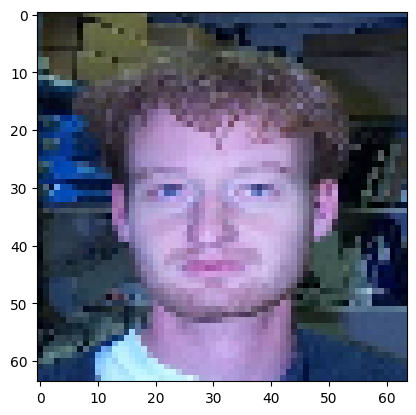

In [12]:
n = 1000
plt.imshow(x_test[n])
print("Preditcted: ",labels[np.argmax(predicted_value[n])])
print("Actual: ", labels[np.argmax(y_test[n])])